In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
import mlxtend as mx
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, fbeta_score, roc_auc_score, roc_curve, precision_recall_curve, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.multiclass import OneVsRestClassifier


In [2]:
path = "C:\\Users\\ssriv\\Warlord\\data mining individual\\dataset\\CDC Diabetes Dataset.csv"

In [3]:
df_import = pd.read_csv(path)

In [4]:
df_import.isna().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [5]:
df_import.duplicated().sum()

23899

In [6]:
df_import = df_import.drop_duplicates()

In [7]:
df_import.duplicated().sum()

0

In [8]:
df_import = df_import.drop(columns=["DiffWalk"])

In [9]:
df_fe = df_import.copy()

In [10]:

df_fe["health_burden"] = (
    df_fe["HighBP"] +
    df_fe["HighChol"] +
    df_fe["HeartDiseaseorAttack"] +
    df_fe["Stroke"]
)


In [11]:
df_fe["lifestyle_risk"] = (
    df_fe["Smoker"] +
    (1 - df_fe["PhysActivity"]) +
    (1 - df_fe["Fruits"]) +
    (1 - df_fe["Veggies"]) +
    df_fe["HvyAlcoholConsump"]
)


In [12]:
df_fe["phys_mental_ratio"] = (
    df_fe["PhysHlth"] / (df_fe["MentHlth"] + 1)
)


In [13]:
df_fe["care_access"] = (
    df_fe["AnyHealthcare"] +
    df_fe["CholCheck"] -
    df_fe["NoDocbcCost"]
)


In [14]:
df_fe[[
    "health_burden",
    "lifestyle_risk",
    "phys_mental_ratio",
    "care_access"
]].describe()


,health_burden,lifestyle_risk,phys_mental_ratio,care_access
count,229781.000000,229781.000000,229781.000000,229781.000000
mean,1.044172,1.385236,2.515669,1.812800
std,0.976528,1.088040,6.535131,0.469426
min,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,1.000000,0.000000,2.000000
50%,1.000000,1.000000,0.000000,2.000000
75%,2.000000,2.000000,1.153846,2.000000
max,4.000000,5.000000,30.000000,2.000000


In [16]:
df_fe.head(15)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,MentHlth,PhysHlth,Sex,Age,Education,Income,health_burden,lifestyle_risk,phys_mental_ratio,care_access
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,18.0,15.0,0.0,9.0,4.0,3.0,2.0,3.0,0.789474,2.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,7.0,6.0,1.0,0.0,3.0,0.000000,-1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,30.0,30.0,0.0,9.0,4.0,8.0,2.0,2.0,0.967742,1.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,11.0,3.0,6.0,1.0,0.0,0.000000,2.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,3.0,0.0,0.0,11.0,5.0,4.0,2.0,0.0,0.000000,2.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,0.0,2.0,1.0,10.0,6.0,8.0,2.0,1.0,2.000000,2.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.0,9.0,6.0,7.0,1.0,4.0,14.000000,2.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,11.0,4.0,4.0,2.0,2.0,0.000000,2.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,30.0,30.0,0.0,9.0,5.0,1.0,3.0,2.0,0.967742,2.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,8.0,4.0,3.0,0.0,2.0,0.000000,2.0


In [17]:
X = df_fe.drop(columns="Diabetes_012")

In [18]:
y = df_fe["Diabetes_012"]

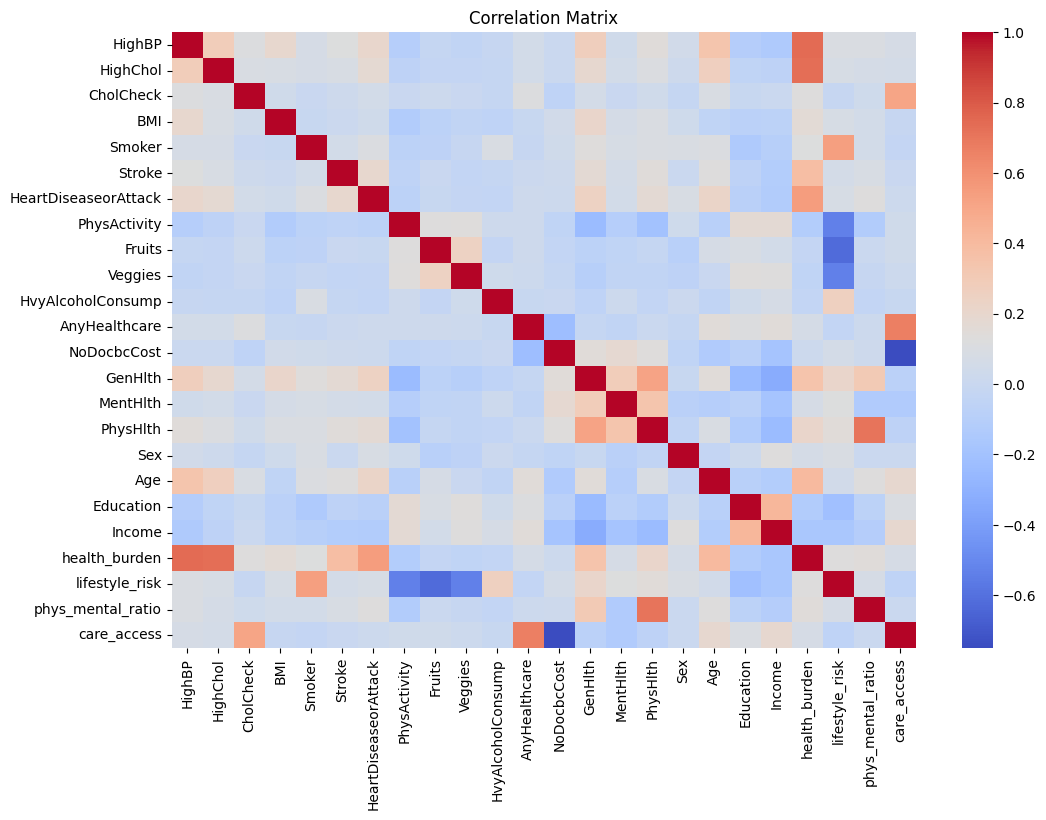

In [19]:

corr = X.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [27]:
# Create upper triangle mask
upper_triangle = np.triu(np.ones(corr.shape), k=1).astype(bool)
upper_corr = corr.where(upper_triangle)

# Find columns with correlation > 0.9
high_corr_pairs = []
to_drop = set()

for col in upper_corr.columns:
    for idx in upper_corr.index:
        if upper_corr.loc[idx, col] > 0.8:
            high_corr_pairs.append((idx, col, upper_corr.loc[idx, col]))
            to_drop.add(col)

# Display highly correlated pairs
print("Pairs with correlation > 0.8:")
for pair in high_corr_pairs:
    print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

print(f"\nColumns to drop ({len(to_drop)}): {list(to_drop)}")

Pairs with correlation > 0.8:

Columns to drop (0): []


In [28]:
# Drop highly correlated columns
X_reduced = X.drop(columns=list(to_drop), errors='ignore')

print(f"Original columns: {len(X.columns)}")
print(f"Columns after filtering: {len(X_reduced.columns)}")
print(f"\nRemaining columns: {X_reduced.columns.tolist()}")

Original columns: 24
Columns after filtering: 24

Remaining columns: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income', 'health_burden', 'lifestyle_risk', 'phys_mental_ratio', 'care_access']


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

def forward_selection_fast(X, max_features=6, sample_size=5000):
    """Forward selection con sampling para velocidad"""
    
    # Usar muestra para acelerar
    if len(X) > sample_size:
        X_sample = X.sample(n=sample_size, random_state=42)
    else:
        X_sample = X
    
    all_features = list(X.columns)
    selected = []
    
    start = time.time()
    
    for i in range(max_features):
        best_score = 0
        best_feature = None
        
        for feature in all_features:
            if feature in selected:
                continue
            
            current_features = selected + [feature]
            X_sub = X_sample[current_features]
            X_scaled = StandardScaler().fit_transform(X_sub)
            
            labels = KMeans(n_clusters=5, random_state=42, n_init=10).fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            
            if score > best_score:
                best_score = score
                best_feature = feature
        
        selected.append(best_feature)
        print(f"{i+1}. Added: {best_feature:<35} Score: {best_score:.4f}")
    
    print(f"\nTime: {time.time() - start:.1f} seconds")
    return selected

selected = forward_selection_fast(X_reduced, max_features=6)

c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **

1. Added: HighBP                              Score: 1.0000


c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **

2. Added: HighChol                            Score: 1.0000
3. Added: CholCheck                           Score: 0.9897
4. Added: health_burden                       Score: 0.8837
5. Added: HeartDiseaseorAttack                Score: 0.7476
6. Added: Stroke                              Score: 0.6171

Time: 71.1 seconds


In [31]:
# ----------------------------
# Feature Importance for Clustering (Before PCA)
# ----------------------------


scaler = StandardScaler()

def evaluate_features(feature_list):
    """Evaluate how well a set of features separates clusters."""
    X_sub = X_reduced[feature_list]
    X_scaled = scaler.fit_transform(X_sub)

    best_score = 0
    
    for k in range(2, 7):
        labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        best_score = max(best_score, score)
        
    return best_score

# Evaluate individual features
scores = {}

for col in X_reduced.columns:
    score = evaluate_features([col])
    scores[col] = score

sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print("Feature ranking (by silhouette score):\n")
print(f"{'Feature':<35} {'Score':>10}")
print("-" * 45)
for f, s in sorted_scores:
    print(f"{f:<35} {s:>10.3f}")

c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\ssriv\anaconda3\envs\warlord\lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **

KeyboardInterrupt: 

In [ ]:
# Select top 4 features based on silhouette score > .80
selected_features = [
    'min_weekly_clicks',
    'engagement_consistency',
    'active_weeks',
    'max_clicks_single_interaction'
]

# Create dataframe with selected features
X_selected = X[selected_features].copy()

print(f"Selected features: {len(selected_features)}")
print(f"Dataset shape: {X_selected.shape}")
print(f"\nFeatures:\n{X_selected.columns.tolist()}")

In [ ]:
from scipy import stats

z_scores = np.abs(stats.zscore(X_selected))
mask = (z_scores < 2).all(axis=1)  
X_clean = X_selected[mask]

print(f"Removed: {len(X_selected) - len(X_clean)} outliers")

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Scale first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_selected.columns)

In [ ]:

# Keep enough components to explain 80–90% variance
pca = PCA(n_components=0.85, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("\nPCA Results")
print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"PCA dimensions: {X_pca.shape[1]}")
print(f"Explained variance ratio per component:")
print(pca.explained_variance_ratio_)
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")


In [ ]:
from sklearn.metrics import silhouette_score

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"PCA dimensions: {X_pca.shape[1]}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# 2. Elbow + Silhouette
k_range = range(2, 11)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca) 
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_pca, labels)) 

# 3. Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].set_xticks(k_range)
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouettes, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Method')
axes[1].set_xticks(k_range)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Results
results_df = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette': silhouettes
})
print(results_df.to_string(index=False))

In [ ]:
# Set optimal k (adjust based on elbow method results)
optimal_k = 5

# Fit K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)  

print(f"K-Means clustering with k={optimal_k}")
print(f"\nCluster distribution:")
print(pd.Series(labels).value_counts().sort_index())

# silhouette
score = silhouette_score(X_pca, labels)
print(f"\nSilhouette Score: {score:.4f}")

In [ ]:
X_original = X_selected.copy()
X_original["cluster"] = labels

print("=== CLUSTER AVERAGE ===")
print(X_original.groupby("cluster")[selected_features].mean().round(2))

print("\n=== DISTRIBUTION    ===")
print(pd.Series(labels).value_counts().sort_index())

In [ ]:
# Delete cluster 4, it only has 8 students
mask_no_outliers = labels != 4

X_pca_clean = X_pca[mask_no_outliers]
X_selected_clean = X_selected[mask_no_outliers]
labels_clean = labels[mask_no_outliers]

print(f"Removed: {(labels == 4).sum()} outliers")
print(f"Remaining: {len(labels_clean)} students")
print(pd.Series(labels_clean).value_counts().sort_index())

In [32]:
lifestyle_features = [
    "BMI",
    "Smoker",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump"
]


health_features = [
    "HighBP",
    "HighChol",
    "HeartDiseaseorAttack",
    "Stroke",
    "GenHlth",
    "PhysHlth",
    "MentHlth"
]


care_features = [
    "AnyHealthcare",
    "CholCheck",
    "NoDocbcCost",
    "Education",
    "Income"
]



In [33]:
def cluster_group(X, features, k_range=range(2, 7)):
    X_sub = X[features]
    X_scaled = StandardScaler().fit_transform(X_sub)

    results = {}

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(X_scaled)

        # Avoid degenerate cases
        if len(np.unique(labels)) < 2:
            continue

        score = silhouette_score(X_scaled, labels)
        results[k] = score

    return results


In [34]:
cluster_group(X_reduced, lifestyle_features)


{2: 0.24377465674236845,
 3: 0.28958510809651467,
 4: 0.33033874249943956,
 5: 0.34087057805299864,
 6: 0.37377070483279295}

In [35]:
cluster_group(X_reduced, health_features)


{2: 0.38165390019721596,
 3: 0.2815736417626565,
 4: 0.3097088767653895,
 5: 0.3407342696538492,
 6: 0.3643763314604779}

In [36]:
cluster_group(X_reduced, care_features)


{2: 0.5463078721140012,
 3: 0.5715846620445867,
 4: 0.43120147716638,
 5: 0.47244439428618273,
 6: 0.47389450697110397}

In [37]:
kmeans_life = KMeans(n_clusters=4, random_state=42, n_init=20)
X_life_scaled = StandardScaler().fit_transform(X_reduced[lifestyle_features])

X_reduced["lifestyle_cluster"] = kmeans_life.fit_predict(X_life_scaled)


In [38]:
X_reduced.groupby("lifestyle_cluster")[lifestyle_features].mean()


,BMI,Smoker,PhysActivity,Fruits,Veggies,HvyAlcoholConsump
lifestyle_cluster,,,,,,
0,29.343977,0.469183,0.615438,0.384407,0.000000,0.0
1,28.087156,0.431653,1.000000,0.703731,1.000000,0.0
2,27.128530,0.654122,0.773692,0.558638,0.841864,1.0
3,30.389592,0.505402,0.004316,0.594459,1.000000,0.0


In [39]:
pd.crosstab(X_reduced["lifestyle_cluster"], X_reduced["Diabetes_012"], normalize="index")


KeyError: 'Diabetes_012'

In [ ]:
X_model = X_reduced.drop(columns=["Diabetes_012"])
